In [1]:
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
import random
import time

In [2]:
# Data is collected from the csv file.
raw_Data = pd.DataFrame(pd.read_csv('municipality_bus_utilization.csv', header=None)).to_numpy()[1:]

# Data is then parsed to a list. Capacity is left out as it isn't relevant for the problem.
bus_Data = []
i = 0
while i < len(raw_Data): 
    data = raw_Data[i]
    date_and_time = data[0].split()
    bus_Date = date_and_time[0]
    raw_Time = date_and_time[1].split(":")
    bus_Time = math.floor(float(raw_Time[0]) + ((float(raw_Time[1])*10/6 + 25)*0.01))
    mun_ID = data[1]
    bus_Usage = int(data[2])
    bus_Data.append([bus_Date, bus_Time, mun_ID, bus_Usage])
    i = i + 1

In [3]:
# Time data is converted to a single hour form. Data from the same hour are summed.
def sum_for_hour(data_Arr):
    data_Dict = {}
    for data in data_Arr:
        data_Key = tuple([data[2], data[0], data[1]])
        if data_Key not in data_Dict:
            data_Dict[data_Key] = 2*int(data[3])
        else:
            data_Dict[data_Key] = data_Dict[data_Key]/2 + int(data[3])
    return list(map(tuple, [(a, dt.datetime.strptime(b + '-' + str(c),'%Y-%m-%d-%H'), d) for (a, b, c), d in data_Dict.items()]))
bus_Data = sum_for_hour(bus_Data)

In [4]:
# Data is interpolated to fill in any missing values.
def interpolate(data_Arr):
    datatype = [('mun ID', 'S1'), ('datetime', 'datetime64[s]'), ('bus usage', int)]
    data_Arr = np.array(data_Arr, dtype = datatype)
    data_Arr = np.sort(data_Arr, order=['mun ID', 'datetime'])

    interp = []
    prev_Usage = 0
    i = 8
    for data in data_Arr:
        date = str(data[1])[:10]
        time = int(str(data[1])[11:13])
        if i == time:
            i = i + 1
        else:
            interp.append((data[0], dt.datetime.strptime(date + '-' + str(time - 1),'%Y-%m-%d-%H'), (data[2] + prev_Usage)*0.5))
            i = i + 2
        prev_Usage = data[2]
        if i > 16:
            i = 8
    interp = np.array(interp, dtype = datatype)
    if interp.size != 0:
        return np.concatenate(data_Arr, interp)
    else:
        return data_Arr
bus_Data = interpolate(bus_Data)

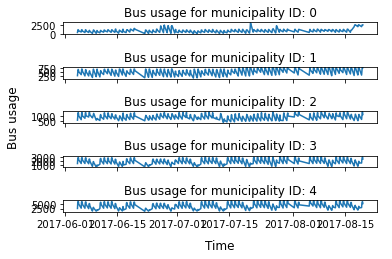

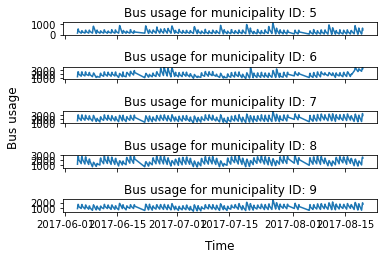

In [5]:
# Bus usages of different municipalities are plotted.
i = 0
j = 0
while j < 2:
    fig, axs = plt.subplots(5, 1, sharex=True)
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel("Time", labelpad = 10, fontsize = 12)
    plt.ylabel("Bus usage", labelpad = 20, fontsize = 12)
    while i < 5:
        ax = axs[i%5]
        ax.title.set_text('Bus usage for municipality ID: ' + str(i + 5*j))
        x_val = [x[1] for x in bus_Data if int(x[0]) == i + 5*j]
        y_val = [x[2] for x in bus_Data if int(x[0]) == i + 5*j]
        ax.plot(x_val, y_val)
        i = i + 1
    plt.tight_layout()
    i = 0
    j = j + 1
plt.show()
plt.close()

In [6]:
# Data is splitted for each municipality.
def separate_data(data_Arr):
    data_Dict = {}
    for data in data_Arr:
        data_Key = int(data[0])
        if int(data_Key) not in data_Dict:
            data_Dict[data_Key] = np.array([[data[1], data[2]]])
        else:
            data_Dict[data_Key] = np.append(data_Dict[data_Key], [[data[1], data[2]]], axis = 0)

    return [data_Dict[0], data_Dict[1], data_Dict[2], data_Dict[3], data_Dict[4], data_Dict[5], data_Dict[6], data_Dict[7], data_Dict[8], data_Dict[9]]
bus_Data = separate_data(bus_Data)

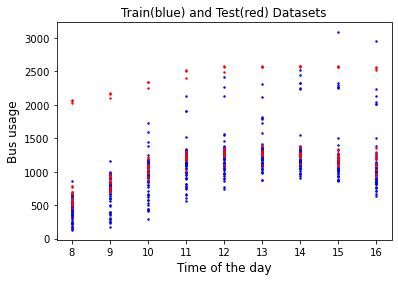

In [7]:
# Plot function for training and testing datasets.
def plot_data(train_Data, test_Data, m = None, b = None, title = None, scatter = True):
    fig = plt.figure()
    if scatter == True:
        plt.scatter(train_Data[:,0], train_Data[:,1], s = 2, color = 'b')
        plt.scatter(test_Data[:,0], test_Data[:,1], s = 2, color = 'r')
    else:
        plt.plot(train_Data[:,0], train_Data[:,1], color = 'b')
        plt.plot(test_Data[:,0], test_Data[:,1], color = 'r')
    if m and b :
        x = np.linspace(0.5, 1, 50)
        y = m*x + b
        plt.plot(x, y, color = 'g')
    plt.xlabel("Time of the day", fontsize = 12)
    plt.ylabel("Bus usage", fontsize = 12)
    if title:
        plt.title(title)
    plt.show()
    plt.close()

# Function to distribute data into training and testing sets. 
# Also modifies data to reduce date-time to only time, stacking all data on one day.
def dist_dataset(data_Arr, plot = True):
    # Selects data for training and testing datasets. The last two weeks are selected for testing, the rest for training.
    train_Data = np.array([data for data in data_Arr if data[0] < np.datetime64('2017-08-05T00:00:00')])
    test_Data = np.array([data for data in data_Arr if data[0] >= np.datetime64('2017-08-05T00:00:00')])
    
    # Reduces date-time to just time.
    for data in train_Data:
        data[0] = int(str(data[0])[11:13])
    for data in test_Data:
        data[0] = int(str(data[0])[11:13])
    
    if plot == True:
        plot_data(train_Data, test_Data, title = "Train(blue) and Test(red) Datasets")

    return train_Data, test_Data

# Data is distributed into training and testesting sets.
dist_dataset(bus_Data[0].copy())

train_Dict = {}
test_Dict = {}
for i in range(10):
    train_Dict[i], test_Dict[i] = dist_dataset(bus_Data[i].copy(), plot = False)

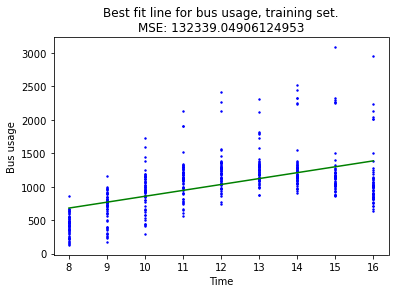

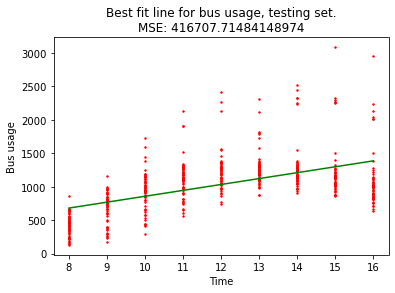

[132339.04906124953, 416707.71484148974, 332381.4888888889]

In [8]:
# Linear regression function.
def lin_regression(train_Data, test_Data, plot = True):
    # x value, y value and total data count are gathered for training set.
    x = train_Data[:,0]
    y = train_Data[:,1]
    n = train_Data.shape[0]
    m_x = np.mean(x)
    m_y = np.mean(y)
 
    # Cross-deviation and deviation of x are calculated.
    SS_xy = np.sum(y*x) - n*m_y*m_x
    SS_xx = np.sum(x*x) - n*m_x*m_x
    
    # Prediction function coefficients are calculated for least squares method.
    b_1 = SS_xy / SS_xx
    b_0 = m_y - b_1*m_x
    y_pred = b_0 + b_1*x
    # MSE (mean squared error) is calculated.
    MSE_training = 1/n*np.sum((y_pred - y)**2)
    
    if plot == True:
        plt.scatter(x, y, color = "blue", s = 2)
        plt.plot(x, y_pred, color = "green")
        plt.title('Best fit line for bus usage, training set.\nMSE: ' + str(MSE_training))
        plt.xlabel('Time')
        plt.ylabel('Bus usage')
        plt.show()
        plt.close()

    # x value, y value and total data count are gathered for testing set.
    x_test = test_Data[:,0]
    y_test = test_Data[:,1]
    n_test = test_Data.shape[0]

    # y values are predicted and MSE is calculated for testing set.
    y_pred_test = b_0 + b_1*x_test
    MSE_testing = 1/n_test*np.sum((y_pred_test - y_test)**2)
    # MSE for the mean prediction is calculated.
    MSE_mean = 1/n_test*np.sum((np.mean(y_test) - y_test)**2)

    if plot == True:
        plt.scatter(x, y, color = "red", s = 2)
        plt.plot(x, y_pred, color = "green")
        plt.title('Best fit line for bus usage, testing set.\nMSE: ' + str(MSE_testing))
        plt.xlabel('Time')
        plt.ylabel('Bus usage')
        plt.show()
        plt.close()

    return [MSE_training, MSE_testing, MSE_mean]

lin_regression(train_Dict[0], test_Dict[0])

In [9]:
MSE_Dict = {}
for i in range(10):
    MSE_Dict[i] = lin_regression(train_Dict[i], test_Dict[i], plot = False)

print('MSE values for different municipalities: (Using Linear Regression)')
for i in range(10):
    print('Municipality:' + str(i) + '\tMSE for training:' + str(MSE_Dict[i][0])[:10] + '\tMSE for testing:' + str(MSE_Dict[i][1])[:10] 
        + '\tMSE improvement for testing:' + str(MSE_Dict[i][2] - MSE_Dict[i][1])[:10] + ', ' + str(100*(MSE_Dict[i][2] - MSE_Dict[i][1])/(MSE_Dict[i][2]))[:4] + '%')

MSE values for different municipalities: (Using Linear Regression)
Municipality:0	MSE for training:132339.049	MSE for testing:416707.714	MSE improvement for testing:-84326.225, -25.%
Municipality:1	MSE for training:17577.6238	MSE for testing:24199.7179	MSE improvement for testing:3835.11905, 13.6%
Municipality:2	MSE for training:41233.0394	MSE for testing:34330.5671	MSE improvement for testing:19336.8253, 36.0%
Municipality:3	MSE for training:455400.805	MSE for testing:399478.924	MSE improvement for testing:91379.8085, 18.6%
Municipality:4	MSE for training:2734134.09	MSE for testing:2401564.44	MSE improvement for testing:137038.124, 5.39%
Municipality:5	MSE for training:25618.8956	MSE for testing:26393.7099	MSE improvement for testing:18598.5937, 41.3%
Municipality:6	MSE for training:237033.536	MSE for testing:335547.749	MSE improvement for testing:16489.0286, 4.68%
Municipality:7	MSE for training:160605.100	MSE for testing:168625.352	MSE improvement for testing:149408.084, 46.9%
Munic

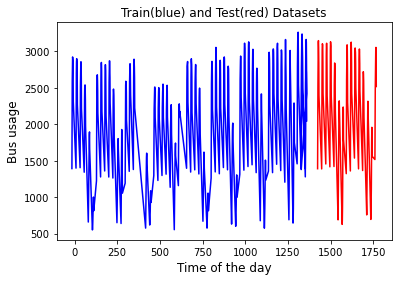

In [13]:
# Simple linear regression was okay but since the data is not so linear, a more complex method can perform better.
# Elman network (recurrent neural network) will be used to predict the bus usage values.

# Function to distribute data into training and testing sets, again. 
# Difference from the previous function is that with this one, date-time aren't reduced but turned into time.
def dist_dataset_2(data_Arr, plot = True):
    # Selects data for training and testing datasets. The last two weeks are selected for testing, the rest for training.
    train_Data = np.array([data for data in data_Arr if data[0] < np.datetime64('2017-08-05T00:00:00')])
    test_Data = np.array([data for data in data_Arr if data[0] >= np.datetime64('2017-08-05T00:00:00')])
    
    # Year, month and day are added to time in the form of hours to obtain one continious data set. 
    # 00:00 AM of a Monday is selected as zero point. The specific date is irrelevant.
    month_day = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]
    for data in train_Data:
        data[0] = str(data[0])
        data[0] = (int(data[0][:4]) - 2017)*365*24 + month_day[int(data[0][5:7]) - 6]*24 + (int(data[0][8:10]) - 4)*24 + int(data[0][11:13])
    for data in test_Data:
        data[0] = str(data[0])
        data[0] = (int(data[0][:4]) - 2017)*365*24 + month_day[int(data[0][5:7]) - 6]*24 + (int(data[0][8:10]) - 4)*24 + int(data[0][11:13])
    
    if plot == True:
        plot_data(train_Data, test_Data, title = "Train(blue) and Test(red) Datasets", scatter = False)

    # Data sets are sorted before being returned.
    datatype = [('total time', int), ('bus usage', int)]
    train_Data = np.array(list([tuple(x) for x in train_Data]), dtype = datatype)
    train_Data = np.sort(train_Data, order = 'total time')
    
    test_Data = np.array(list([tuple(x) for x in test_Data]), dtype = datatype)
    test_Data = np.sort(test_Data, order = 'total time')

    return train_Data, test_Data

train_Dict = {}
test_Dict = {}

dist_dataset_2(bus_Data[3].copy())
for i in range(10):
    train_Dict[i], test_Dict[i] = dist_dataset_2(bus_Data[i].copy(), plot = False)

In [14]:
# Neuron class for Elman Network.
class Neuron():
    def __init__(self, u_dim, x_dim, y_dim, learning_rate = 1e-2, activation_type = "tanh"):
        # Neuron is initialized.
        self.u_dim = u_dim
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.learning_rate = learning_rate
        self.activation_type = activation_type

        self.reset()

    def reset(self):
        # Starting weight values are randomly selected from [-0.5, 0.5].
        # Context layer, hidden layer and input layer weights are stored in a single neuron object.
        self.w_u = np.zeros((1, self.u_dim), dtype=float)
        for i in range(self.u_dim):
            self.w_u[0,i] = np.random.rand()*0.1 - 0.05

        self.w_x = np.zeros((1, self.x_dim), dtype=float)
        for i in range(self.x_dim):
            self.w_x[0,i] = np.random.rand()*0.1 - 0.05

        self.w_y = np.zeros((self.y_dim, 1), dtype=float)
        for i in range(self.y_dim):
            self.w_y[i,0] = np.random.rand()*0.1 - 0.05

        # Previous values for weights are stored to be used in momentum calculation.
        self.w_u_prev = self.w_u
        self.w_x_prev = self.w_x
        self.w_y_prev = self.w_y

        self.data = np.zeros((self.u_dim, 1), dtype=float)

    def forward(self, data, prevx):
        # Forward propagation to find output (x(k)). Input is the data (u(k)) and previous output values (x(k-1)).
        self.data = np.array(data).reshape((self.u_dim, 1))
        self.lin_comb = np.dot(self.w_u,self.data) + np.dot(self.w_x,prevx)
        self.activation = self.activation_function(self.lin_comb)
        return self.activation

    def activation_function(self, data):
        # Activation function of the neuron. Derivative is also gathered to be used for gradient descent.
        if self.activation_type == "tanh":
            y = tanh(data)
            self.activation_derivative = y[1]
            return y[0]
        elif self.activation_type == "sigmoid":
            y = sigmoid(data)
            self.activation_derivative = y[1]
            return y[0]
        else:
            return data

    def updateN(self, w_u, w_x, w_y):
        # Updates weight values. Momentum is utilized to perform a faster and more precise training process.
        # To disable momentum, set the value to 0.
        momentum = 0.9
        moment_u = momentum*(self.w_u - self.w_u_prev)
        moment_x = momentum*(self.w_x - self.w_x_prev)
        moment_y = momentum*(self.w_y - self.w_y_prev)
        self.w_u_prev = self.w_u
        self.w_x_prev = self.w_x
        self.w_y_prev = self.w_y
        self.w_u = w_u + moment_u
        self.w_x = w_x + moment_x
        self.w_y = w_y + moment_y

In [15]:
# A linked list structure to be used at the input of the neural network.
class YNode():
    # In a node; x value, actual y value, predicted y value and a link to the previous node are stored.
    def __init__(self, x_val, y_val, yprev = None, ypred = random.random()):
        self.x_val = x_val
        self.y_val = y_val 
        self.pred = ypred
        if x_val > 0:
            # Links are attached only if the node is not the initial node.
            # Initial node links to itself.
            self.links(yprev)

    # Sets link to the previous node.
    def links(self, yprev):
        self.prev = yprev

    # Used to set link and y value manually.
    def setnode(self, y_val, yprev):
        self.y_val = y_val   
        self.prev = yprev

In [17]:
# Consant values for the network.
dim = 5         # Number of context units.
y_dim = 1       # Output dimensions.
x_dim = 5       # Hidden layer dimensions.
epoch = 100     # The total number of iterations in training.
eth = 1e-4      # Error threshold.

In [18]:
# Hyperbolic tangent function.
def tanh(x):
    t=(np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
    dt=1-t**2
    return t,dt

# Logistic function.
def sigmoid(x):
    s=1/(1+math.exp(-x))
    ds=s*(1-s)  
    return s,ds

# Network generating function.
def generate_network(learning_rate, activation_type):
    network = []
    # Generates a network with the selected learning rate and activation function
    # Activation function is only utilized in hidden layer in Elman network. This is why
    # neurons are only generated for the hidden layer. Weights of other layers can be stored
    # in these neurons.
    for i in range(x_dim):
        # x_dim, y_dim ve dim respectively represent; neuron count of the hidden layer, output dimensions and input data dimensions.
        new_Neuron = Neuron(dim, x_dim, y_dim, learning_rate, activation_type)
        network.append(new_Neuron)
    return network

In [22]:
# Training process.
def training_process(network, node_List, epoch, eth):
    prevx = np.zeros((x_dim,1), dtype=float) + 0.5
    currx = np.zeros(x_dim, dtype=float).reshape(x_dim,1)
    Eortprev = 0
    last_iter = epoch
    # The training lasts for 'epoch' iterations.
    for i in range(epoch):
        Eort = 0

        for node in node_List:
            j = 0
            # Input data is selected as the previous five values of the output.
            data = np.array([node.prev.prev.prev.prev.prev.y_val, 
                            node.prev.prev.prev.prev.y_val, 
                            node.prev.prev.prev.y_val, 
                            node.prev.prev.y_val, 
                            node.prev.y_val], dtype=float).reshape(dim, 1)
            # Hidden layer outputs (x(k)) are calculated.
            for neuron in network:
                x_j = neuron.forward(data, prevx)
                currx[j] = x_j
                
                # Output layer weights are pulled.
                if j == 0:
                    w_y = neuron.w_y
                else:
                    w_y = np.concatenate((w_y, neuron.w_y), axis=1)
                j += 1

            # Network output and error are calculated.

            curry = np.dot(w_y, currx)
            node.pred = curry
            e = node.y_val - curry
            E = (e**2)/2

            # Network is updated using the previously calculated error.
            update(network, e, prevx)

            # Hidden layer output (x(k)) is saved to be used as 'context unit' (x(k-1)).
            Eort += E
            prevx = currx
        # Average squared error is calculated.
        Eort = Eort/len(node_List)
        # Average squared error is compared to the error threshold to stop the training.
        if (abs(Eortprev - Eort) < (Eort*eth)) or (Eort < eth):
            last_iter = i+1
            break
        Eortprev = Eort
    # Last iteration count and average squared error are returned.
    return [last_iter, Eort]

# Network updating function.
def update(network, error, prevx):
    # Weights are pulled from the network, updated and set again in the network.
    init_step = 0
    for neuron in network:
        # Weights of the neuron, hidden layer outputs, activation derivatives, input data and learning rate are pulled from the network.
        if init_step == 0:
            w_u = neuron.w_u
            w_x = neuron.w_x
            w_y = neuron.w_y
            x_vec = np.array(neuron.activation, dtype=float).reshape(1,1)
            act_derivative_vec = np.array(neuron.activation_derivative, dtype=float).reshape(1,1)
            u_vec = neuron.data
            learning_rate = neuron.learning_rate

            init_step += 1
        else:
            w_u = np.concatenate((w_u, neuron.w_u), axis=0)
            w_x = np.concatenate((w_x, neuron.w_x), axis=0)
            w_y = np.concatenate((w_y, neuron.w_y), axis=1)
            x_vec = np.concatenate((x_vec, np.array(neuron.activation, dtype=float).reshape(1,1)), axis=0)
            act_derivative_vec = np.concatenate((act_derivative_vec, np.array(neuron.activation_derivative, dtype=float).reshape(1,1)), axis=0)

    # New weights are calculated.
    new_w_y = w_y + learning_rate * np.dot(error,np.transpose(x_vec))
    new_w_x = w_x + learning_rate * (np.dot(np.transpose(w_y),error) * np.dot(act_derivative_vec,np.transpose(prevx)))
    new_w_u = w_u + learning_rate * (np.dot(np.transpose(w_y),error) * np.dot(act_derivative_vec,np.transpose(u_vec)))
    
    i = 0
    # The weights in the network are updated with the new weights.
    for neuron in network:
        w_u = np.array(new_w_u[i,:], dtype=float).reshape(1, dim)
        w_x = np.array(new_w_x[i,:], dtype=float).reshape(1, x_dim)
        w_y = np.array(new_w_y[:,i], dtype=float).reshape(y_dim, 1)

        neuron.updateN(w_u, w_x, w_y)

        i += 1

# Test function.
def testNetwork(node_List, network, maxval, minval, prevx = 0):
    # Tests the network using a dataset.
    # Testing process is similar to the forward propagation. Network output is gathered using data.
    # The difference between the data and prediction, error, is averaged. MSE (mean squared error) is also calculated.
    # Weights in the network will not be updated during testing process.

    # Since testing process is right after training, last x value of training 
    # is selected to be used as the previous x value at the start of testing.
    if not isinstance(prevx, np.ndarray):
        prevx = np.zeros((x_dim,1), dtype=float) + 0.5
    currx = np.zeros(x_dim, dtype=float).reshape(x_dim,1)
    Eort = 0
    e2sum = 0
    for node in node_List:
        j = 0
        data = np.array([node.prev.prev.prev.prev.prev.y_val, 
                        node.prev.prev.prev.prev.y_val, 
                        node.prev.prev.prev.y_val, 
                        node.prev.prev.y_val, 
                        node.prev.y_val], dtype=float).reshape(dim, 1)
        for neuron in network:
            x_j = neuron.forward(data, prevx)
            currx[j] = x_j
            if j == 0:
                w_y = neuron.w_y
            else:
                w_y = np.concatenate((w_y, neuron.w_y), axis=1)
            j += 1
        curry = np.dot(w_y, currx)
        e = node.y_val - curry
        E = e**2
        Eort += E/2
        node.pred = curry
        prevx = currx

        y_val_dscl = minval + node.y_val*(maxval - minval)
        y_pred_dscl = minval + node.pred.flatten()*(maxval - minval)
        e2sum += (y_pred_dscl - y_val_dscl)**2
    MSE = 1/len(node_List)*e2sum
    Eort = (Eort/len(node_List)).reshape(1)
    return Eort, prevx, MSE

# Gets MSE value for the mean.
def get_MSE_mean(node_List, maxval, minval):
    # Mean of the values is calculated
    ysum = 0
    for node in node_List:
        ysum += minval + node.y_val*(maxval - minval)
    ymean = ysum/len(node_List)

    # Average MSE is calculated and returned.
    e2sum = 0
    for node in node_List:
        e2sum += (ymean - node.y_val)**2
    MSE_mean = 1/len(node_List)*e2sum
    return MSE_mean

# Plots the data, prediction and comparisons.
def plotcomparison(train_List, test_List, maxval, minval):

    plt.figure()
    x = []
    y = []
    for node in train_List:
        x = x + [node.x_val]
        y = y + [minval + node.y_val*(maxval - minval)]
    plt.plot(x, y, color = 'blue', label='Data')
    plt.title("Actual Data (Training Set)")
    plt.show()
    plt.close()

    # Ağın çiziminde de benzer bir şekilde iki ardışık düğümün tahmini değerleri arasında
    # aralıklı bir dii oluşturularak çizdirilir. Bu tahmini değer eğitilmiş ağ ile test sonucu
    # elde edilir.
    plt.figure()
    x = []
    y = []
    for node in train_List:
        x = x + [node.x_val]
        y = y + [minval + node.pred.flatten()*(maxval - minval)]
    plt.plot(x, y, color = 'red')
    plt.title("Prediction (Training Set)")
    plt.show()
    plt.close()

    # İki çizim aynı anda uygulanıp karşılaştırma çizilir.
    plt.figure()
    x = []
    y_real = []
    y_pred = []
    for node in train_List:
        x = x + [node.x_val]
        y_real = y_real + [minval + node.y_val*(maxval - minval)]
        y_pred = y_pred + [minval + node.pred.flatten()*(maxval - minval)]
    plt.plot(x, y_pred, color = 'red', label='Prediction')
    plt.plot(x, y_real, color = 'blue', label='Data')
    plt.title("Comparison of Data and Prediction (Training Set)")
    plt.show()
    plt.close()

    # Aynı işlemler test kümesi için de yapılır.
    plt.figure()
    x = []
    y = []
    for node in test_List:
        x = x + [node.x_val]
        y = y + [minval + node.y_val*(maxval - minval)]
    plt.plot(x, y, color = 'blue')
    plt.title("Actual Data (Testing Set)")
    plt.show()
    plt.close()

    plt.figure()
    x = []
    y = []
    for node in test_List:
        x = x + [node.x_val]
        y = y + [minval + node.pred.flatten()*(maxval - minval)]
    plt.plot(x, y, color = 'red')
    plt.title("Prediction (Testing Set)")
    plt.show()
    plt.close()

    plt.figure()
    x = []
    y_real = []
    y_pred = []
    for node in test_List:
        x = x + [node.x_val]
        y_real = y_real + [minval + node.y_val*(maxval - minval)]
        y_pred = y_pred + [minval + node.pred.flatten()*(maxval - minval)]
    plt.plot(x, y_pred, color = 'red', label='Prediction')
    plt.plot(x, y_real, color = 'blue', label='Data')
    plt.title("Comparison of Data and Prediction (Testing Set)")
    plt.show()
    plt.close()

    # Ardından y(k) ve y(k-1) gerçek ve tahmini değerleri çekilir. Bu değerler kullanılarak
    # durum portreleri çizdirilir ve kaydedilir. 
    # Veriler çekilirken geri ölçeklendirme uygulanmaktadır.
    trainingList_x = []
    trainingList_y = []
    for node in train_List:
        trainingList_x.append(float(minval + node.prev.y_val*(maxval - minval)))
        trainingList_y.append(float(minval + node.y_val*(maxval - minval)))

    trainingListPred_x = []
    trainingListPred_y = []
    for node in train_List:
        trainingListPred_x.append(float(minval + node.prev.pred*(maxval - minval)))
        trainingListPred_y.append(float(minval + node.pred*(maxval - minval)))


    testingList_x = []
    testingList_y = []
    for node in test_List:
        testingList_x.append(float(minval + node.prev.y_val*(maxval - minval)))
        testingList_y.append(float(minval + node.y_val*(maxval - minval)))

    testingListPred_x = []
    testingListPred_y = []
    for node in test_List:
        testingListPred_x.append(float(minval + node.prev.pred*(maxval - minval)))
        testingListPred_y.append(float(minval + node.pred*(maxval - minval)))

    plt.figure()
    plt.plot(trainingListPred_x, trainingListPred_y, color = 'red')
    plt.title("State Diagram of Prediction (Training Set)")
    plt.show()
    plt.close()

    plt.figure()
    plt.plot(trainingList_x, trainingList_y, color = 'blue')
    plt.title("State Diagram of the Data (Training Set)")
    plt.show()
    plt.close()

    plt.figure()
    plt.plot(trainingListPred_x, trainingListPred_y, color = 'red', label='Prediction')
    plt.plot(trainingList_x, trainingList_y, color = 'blue', label='Data')
    plt.title("Comparison of State Diagrams (Training Set)")
    plt.show()
    plt.close()
    
    plt.figure()
    plt.plot(testingListPred_x, testingListPred_y, color = 'red')
    plt.title("State Diagram of Prediction (Testing Set)")
    plt.show()
    plt.close()

    plt.figure()
    plt.plot(testingList_x, testingList_y, color = 'blue', label='Gerçekte olan')
    plt.title("State Diagram of the Data (Testing Set)")
    plt.show()
    plt.close()

    plt.figure()
    plt.plot(testingListPred_x, testingListPred_y, color = 'red', label='Tahmin edilen')
    plt.plot(testingList_x, testingList_y, color = 'blue', label='Gerçekte olan')
    plt.title("Comparison of State Diagrams (Testing Set)")
    plt.show()
    plt.close()    

In [25]:
MSE_Dict_2 = {}
# The network is initiated for all municipalities.
for i in range(10):
 
    # Starting conditions are initiated, y(0) = 0.1 is chosen.
    yinit = YNode(0, 0)
    yinit.setnode(0.1, yinit)
    yinit.pred = 0.1
    yprev = yinit

    # Training and testing sets are converted to the YNode linked list object.
    train_List = []
    for j in range(train_Dict[i].shape[0]):
        y = YNode(train_Dict[i][j][0], train_Dict[i][j][1], yprev)
        yprev = y
        train_List.append(yprev)

    test_List = []
    for j in range(test_Dict[i].shape[0]):
        y = YNode(test_Dict[i][j][0], test_Dict[i][j][1], yprev)
        yprev = y
        test_List.append(yprev)

    # Max and min values of the data are gathered for descaling.
    maxval = 0
    minval = 0
    for node in train_List:
        if node.y_val > maxval:
            maxval = node.y_val
        if node.y_val < minval:
            minval = node.y_val

    # The data are scaled between 0 and 1.
    for node in train_List:
        node.y_val = (node.y_val - minval)/(maxval - minval)
    for node in test_List:
        node.y_val = (node.y_val - minval)/(maxval - minval)

    # Training runs for some iterations, after which the best performing network is chosen.
    # Change the value "x" in "range(x)" to select how many iterations the process should run.
    best_result = None
    for j in range(5):
        # Elman network is generated.
        network = generate_network(0.1, "sigmoid")

        # The training process gets started.
        start_time = time.time()
        result = training_process(network, train_List, epoch, eth)
        print("%d. iteration for %d municipality is complete. Training time: %.3f seconds" % (j + 1, i, time.time() - start_time))

        # The network with the lowest error will be chosen in the end.
        if best_result != None:
            if result[1] < best_result:
                best_network = network[:]
                best_result = result[1]
        else:
            best_network = network[:]
            best_result = result[1]
        network.clear()

    # Network is tested with training and testing sets.
    edresult = testNetwork(train_List, best_network, maxval, minval)
    result = testNetwork(test_List, best_network, maxval, minval, edresult[1])
    MSE_Dict_2[i] = [edresult[2], result[2], get_MSE_mean(test_List, maxval, minval)]
    best_network.clear()
    if i == 0:
        plotcomparison(train_List, test_List, maxval, minval)
        plt.close()

print('MSE values for different municipalities: (Using Elman Network)')
for i in range(10):
    print('Municipality:' + str(i) + '\tMSE for training:' + str(MSE_Dict_2[i][0])[1:11] + '\tMSE for testing:' + str(MSE_Dict_2[i][1])[1:11] 
        + '\tMSE improvement for testing:' + str(MSE_Dict_2[i][2] - MSE_Dict_2[i][1])[1:11] + ', ' + str(100*(MSE_Dict_2[i][2] - MSE_Dict_2[i][1])/(MSE_Dict_2[i][2]))[1:5] + '%')

AttributeError: 'YNode' object has no attribute 'prev'